In [1]:
import numpy as np
import pickle
import os
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from scipy import stats

/home/luqman/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data preparation

In [2]:
train_label_path = '/nas/project_data/B1_Behavior/hakim/UDIVA/label/train'
val_label_path = '/nas/project_data/B1_Behavior/hakim/UDIVA/label/val'
test_label_path = '/nas/project_data/B1_Behavior/hakim/UDIVA/label/test'
train_data_path = '/nas/project_data/B1_Behavior/hakim/UDIVA/pose_face_moves/train'
val_data_path = '/nas/project_data/B1_Behavior/hakim/UDIVA/pose_face_moves/val'
test_data_path = '/nas/project_data/B1_Behavior/hakim/UDIVA/pose_face_moves/test'

train_features = []
train_labels = []
val_features = []
val_labels = []
test_features = []
test_labels = []

In [3]:
def split_feature(feature, size):
    p = 0
    splitted_feature = []
    
    for i in range(int(len(feature)/size)):
        splitted_feature.append(feature[p:p+size, :])
        p += size
        
    return splitted_feature

In [4]:
for item in os.listdir(train_data_path):    
    label_path = os.path.join(train_label_path, item)
    with open(label_path, 'rb') as f:
        label = np.load(f)
    
    input_path = os.path.join(train_data_path, item)
    with open(input_path, 'rb') as f:
        feature = np.load(f)    
    
    splitted_features = split_feature(feature, 2700)
    
    for item in splitted_features:
        train_features.append(item)
        train_labels.append(label)

In [5]:
for item in os.listdir(val_data_path):    
    input_path = os.path.join(val_data_path, item)
    with open(input_path, 'rb') as f:
        feature = np.load(f)    
    
    label_path = os.path.join(val_label_path, item)
    with open(label_path, 'rb') as f:
        label = np.load(f)
    
    splitted_features = split_feature(feature, 2700)
    
    for item in splitted_features:
        val_features.append(item)
        val_labels.append(label)

In [6]:
for item in os.listdir(test_data_path):    
    input_path = os.path.join(test_data_path, item)
    with open(input_path, 'rb') as f:
        feature = np.load(f)
     
    label_path = os.path.join(test_label_path, item)
    with open(label_path, 'rb') as f:
        label = np.load(f)
    
    splitted_features = split_feature(feature, 2700)
    
    for item in splitted_features:
        test_features.append(item)
        test_labels.append(label)

In [7]:
print(len(train_features))
print(len(val_features))
print(len(test_features))

2874
500
198


In [8]:
BATCH_SIZE = 128
train_features = torch.Tensor(np.array(train_features))
train_labels = torch.Tensor(np.array(train_labels))
val_features = torch.Tensor(np.array(val_features))
val_labels = torch.Tensor(np.array(val_labels))
test_features = torch.Tensor(np.array(test_features))
test_labels = torch.Tensor(np.array(test_labels))

In [9]:
train_ds = TensorDataset(train_features, train_labels)
val_ds = TensorDataset(val_features, val_labels)
test_ds = TensorDataset(test_features, test_labels)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

# Model

In [10]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [11]:
class LSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_dim, dropout, num_layers, bidirectional, batch_size):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.dropout = dropout
        self.lstm = torch.nn.LSTM(input_size=self.input_size, 
                                hidden_size=self.hidden_size,
                                num_layers=self.num_layers,
                                dropout=self.dropout,
                                bidirectional=bidirectional,
                                batch_first=True)
        self.fc = torch.nn.Linear(hidden_size*2 if bidirectional else hidden_size, output_dim)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.relu(out[:, -1, :])
        out = self.fc(out)
        out = self.sigmoid(out)
        return out

# Training

In [12]:
def train(model, train_loader, val_loader, epochs, patience=5):
    train_losses = []
    val_losses = []
    val_maes = []
    last_loss = 1e-8
    trigger_times = 0

    for epoch in range(0, epochs):
        model.train()
        batch_losses = []

        for inputs, targets in train_loader:
            preds = model(inputs.to(device))
            loss = loss_fn(preds, targets.to(device))
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            optimizer.step()
            batch_losses.append(loss.item())

        train_loss = np.mean(batch_losses)
        train_losses.append(train_loss)

        model.eval()
        with torch.no_grad():
            batch_val_losses = []
            batch_val_mae = []

            for inputs, targets in val_loader:
                preds = model(inputs.to(device))
                loss = loss_fn(preds, targets.to(device))
                batch_val_losses.append(loss.item())
                val_mae = mae(preds, targets.to(device))
                batch_val_mae.append(val_mae.item())
            
            val_loss = np.mean(batch_val_losses)
            val_mae = np.mean(batch_val_mae)
            scheduler.step(val_loss)
            val_losses.append(val_loss)
            val_maes.append(val_mae)
  
        print(f'Epoch {epoch} - train loss: {train_loss:.4f} - val loss: {val_loss:.4f} - val 1-mae: {(1-val_mae):.4f}')
        
        if val_loss > last_loss:
            trigger_times += 1
            print('Trigger:', trigger_times)
            if trigger_times >= patience:
                print('Early stop')
                break
        else:
            print('Trigger: 0')
            trigger_times = 0
        last_loss = val_loss
        
    return train_losses, val_losses, val_maes

In [13]:
LR = 0.001
lstm = LSTM(input_size=5, hidden_size=128, output_dim=5, dropout=0.1, 
            num_layers=2, bidirectional=True, batch_size=BATCH_SIZE)
lstm.to(device)
optimizer = torch.optim.AdamW(lstm.parameters(), lr=LR, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
loss_fn = torch.nn.MSELoss()
mae = torch.nn.L1Loss()

In [15]:
train_losses, val_losses, val_maes = train(lstm, train_loader, val_loader, epochs=50, patience=5)

Epoch 0 - train loss: 1.1963 - val loss: 1.0331 - val 1-mae: 0.1893
Trigger: 1
Epoch 1 - train loss: 1.0913 - val loss: 1.0205 - val 1-mae: 0.1995
Trigger: 0
Epoch 2 - train loss: 1.0851 - val loss: 1.0269 - val 1-mae: 0.1949
Trigger: 1
Epoch 3 - train loss: 1.0831 - val loss: 1.0274 - val 1-mae: 0.1965
Trigger: 2
Epoch 4 - train loss: 1.0828 - val loss: 1.0290 - val 1-mae: 0.1953
Trigger: 3
Epoch 5 - train loss: 1.0825 - val loss: 1.0284 - val 1-mae: 0.1910
Trigger: 0
Epoch 6 - train loss: 1.0808 - val loss: 1.0205 - val 1-mae: 0.1988
Trigger: 0
Epoch 7 - train loss: 1.0758 - val loss: 1.0355 - val 1-mae: 0.1930
Trigger: 1
Epoch 8 - train loss: 1.0775 - val loss: 1.0271 - val 1-mae: 0.1955
Trigger: 0
Epoch 9 - train loss: 1.0768 - val loss: 1.0220 - val 1-mae: 0.1964
Trigger: 0
Epoch 10 - train loss: 1.0733 - val loss: 1.0317 - val 1-mae: 0.1916
Trigger: 1
Epoch 11 - train loss: 1.0736 - val loss: 1.0378 - val 1-mae: 0.1939
Trigger: 2
Epoch 12 - train loss: 1.0721 - val loss: 1.0312 -

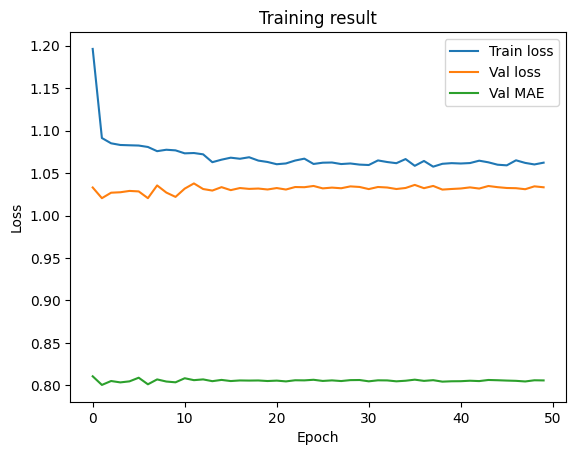

In [17]:
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train loss')
ax.plot(val_losses, label='Val loss')
ax.plot(val_maes, label='Val MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.title("Training result")
plt.legend()

# Testing

In [18]:
def test(model, test_loader):
    mae = torch.nn.L1Loss()
    predictions = np.array([])
    labels = np.array([])
    model.eval()
    with torch.no_grad():
        batch_loss_ext = []
        batch_loss_neu = []
        batch_loss_agr = []
        batch_loss_con = []
        batch_loss_ope = []

        for inputs, targets in test_loader:
            batch_preds = model(inputs.to(device))
            loss_ext = mae(batch_preds[:,0], targets[:,0].to(device))
            loss_neu = mae(batch_preds[:,1], targets[:,1].to(device))
            loss_agr = mae(batch_preds[:,2], targets[:,2].to(device))
            loss_con = mae(batch_preds[:,3], targets[:,3].to(device))
            loss_ope = mae(batch_preds[:,4], targets[:,4].to(device))
            batch_loss_ext.append(loss_ext.item())
            batch_loss_neu.append(loss_neu.item())
            batch_loss_agr.append(loss_agr.item())
            batch_loss_con.append(loss_con.item())
            batch_loss_ope.append(loss_ope.item())
            predictions = np.vstack((predictions, batch_preds.cpu())) if len(predictions) != 0 else batch_preds.cpu()
            labels = np.vstack((labels, targets.cpu())) if len(labels) != 0 else targets.cpu()

        loss_ext = 1 - np.mean(batch_loss_ext)
        loss_neu = 1 - np.mean(batch_loss_neu)
        loss_agr = 1 - np.mean(batch_loss_agr)
        loss_con = 1 - np.mean(batch_loss_con)
        loss_ope = 1 - np.mean(batch_loss_ope)
        loss = (loss_ext + loss_neu + loss_agr + loss_con + loss_ope) / 5

        print(f'1-MAE: {loss:.4f}')
        print(f'1-MAE O: {loss_ope:.4f}')
        print(f'1-MAE C: {loss_con:.4f}')
        print(f'1-MAE E: {loss_ext:.4f}')
        print(f'1-MAE A: {loss_agr:.4f}')
        print(f'1-MAE N: {loss_neu:.4f}')
        
        spearman_r_ext = stats.spearmanr(predictions[:,0], labels[:,0])
        spearman_r_neu = stats.spearmanr(predictions[:,1], labels[:,1])
        spearman_r_agr = stats.spearmanr(predictions[:,2], labels[:,2])
        spearman_r_con = stats.spearmanr(predictions[:,3], labels[:,3])
        spearman_r_ope = stats.spearmanr(predictions[:,4], labels[:,4])
        print(f'O - R: {spearman_r_ope[0]:.3f} - p: {spearman_r_ope[1]:.3f}')
        print(f'C - R: {spearman_r_con[0]:.3f} - p: {spearman_r_con[1]:.3f}')
        print(f'E - R: {spearman_r_ext[0]:.3f} - p: {spearman_r_ext[1]:.3f}')
        print(f'A - R: {spearman_r_agr[0]:.3f} - p: {spearman_r_agr[1]:.3f}')
        print(f'N - R: {spearman_r_neu[0]:.3f} - p: {spearman_r_neu[1]:.3f}')

In [20]:
test(lstm, test_loader)

1-MAE: 0.1980
1-MAE O: 0.0268
1-MAE C: 0.2366
1-MAE E: 0.3254
1-MAE A: 0.0718
1-MAE N: 0.3293
O - R: -0.145 - p: 0.041
C - R: -0.323 - p: 0.000
E - R: -0.057 - p: 0.422
A - R: 0.108 - p: 0.129
N - R: 0.007 - p: 0.923


In [21]:
prior = test_labels.mean(axis=0)
test_prior = torch.from_numpy(np.repeat(np.expand_dims(prior, axis=0), 198, axis=0))
value = mae(test_prior, test_labels)
print('baseline prior 1-mae:', 1-value.item())

baseline prior 1-mae: 0.22506475448608398
